# Kaggle's Titanic Dataset

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ship_sets = (train, test)

## 1. EDA (Exploratory Data Analysis)

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

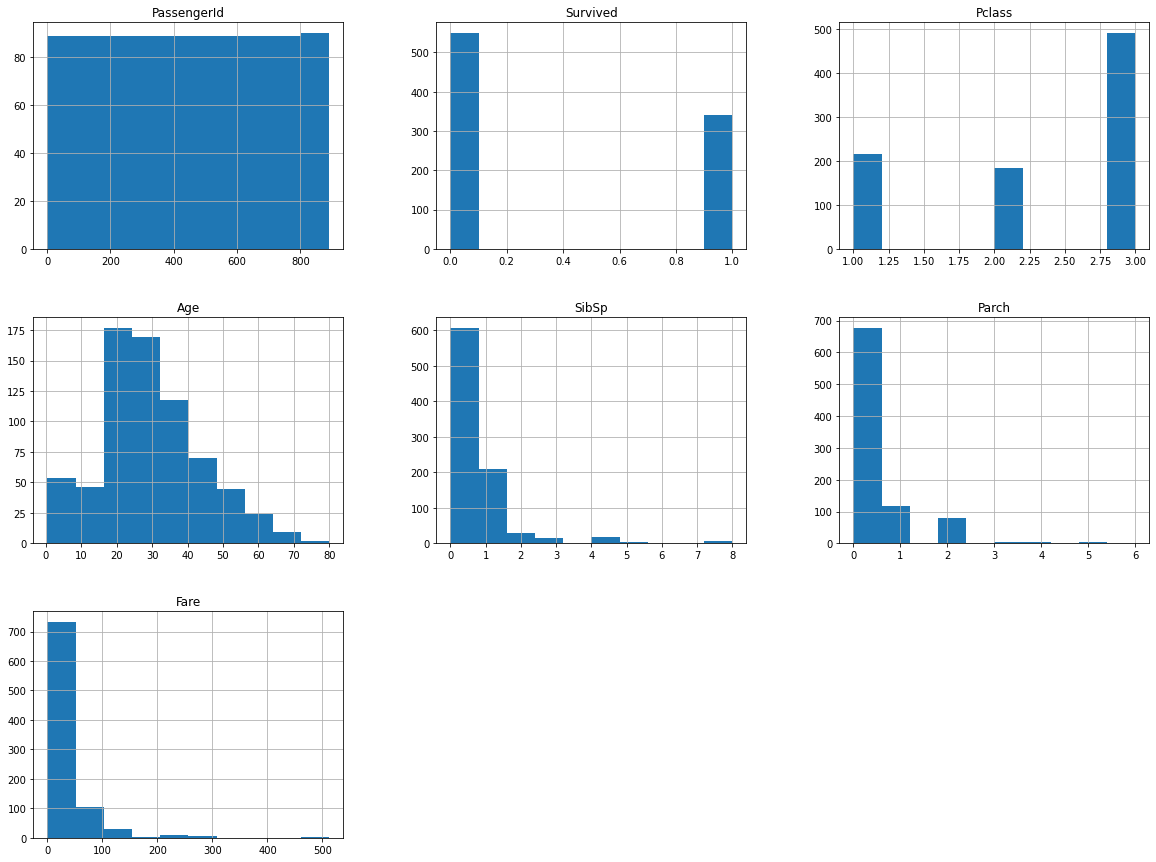

In [4]:
train.hist(figsize=((20, 15)))

In [5]:
train.info()
print("-"*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [6]:
def percent_missing(column):
    return round((column.isnull().sum()/len(column))*100, 2)

missing_values_col = ("Age", "Fare", "Cabin", "Embarked")
for data in ship_sets:
    for col in missing_values_col:
        print(col, percent_missing(data[col]))

Age 19.87
Fare 0.0
Cabin 77.1
Embarked 0.22
Age 20.57
Fare 0.24
Cabin 78.23
Embarked 0.0


891 instances in training set, 418 in test set.

Missing values:

- Training set: {Age 20%, Cabin 77%, Embarked 0.22%}
- Test set: {Age 21%, Cabin 78%, Fare 0.24%}

### PassengerID

By looking at the data, PassengerID is the unique ID given to each passenger (matches the index number).

**Conclusion**:  
It can be safely dropped.

### Cabin

Let's take a look at `Cabin` since it has the most missing values.

In [7]:
train["Cabin"].describe()

count             204
unique            147
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

In [8]:
cabin_survival = train[['Cabin', 'Survived']].groupby(['Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)
cabin_survival

,Cabin,Survived
73,C62 C64,1.0
97,D21,1.0
94,D17,1.0
95,D19,1.0
60,C148,1.0
...,...,...
67,C46,0.0
64,C30,0.0
59,C128,0.0
56,C124,0.0


There's 77% missing values from both training and test set. There's 147 unique values and not sure if there's any correlation to survival rate.

**Conclusion**:  
It's probably best to drop this feature altogether since it would be too hard to fill in missing values in the test set.

### Ticket

Let's look at Ticket number since it should be similar to Cabin number.

In [9]:
train["Ticket"].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [10]:
ticket_survival = train[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean().sort_values(by='Survived', ascending=False)
ticket_survival

,Ticket,Survived
0,110152,1.0
180,26360,1.0
483,386525,1.0
479,382651,1.0
151,244373,1.0
...,...,...
385,349246,0.0
384,349245,0.0
197,2669,0.0
382,349243,0.0


Similar to Cabin numbers, there's 681 unique values and not sure if there's any correlation to survival rate.

**Conclusion**:  
It's probably safe to drop this feature altogether also.

### Embarked

- C = Cherbourg
- Q = Queenstown
- S = Southampton

In [11]:
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


55% of survivors embarked from Cherbourg.

**Conclusion**:  
This seems significant enough to warrant keeping.

### Pclass

- 1 = 1st
- 2 = 2nd
- 3 = 3rd

In [12]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


62% of survivors are Pclass=1 "first class".

**Conclusion**:  
This seems significant enough to keep. Also makes sense following the assumption:  
(Women & Children -> Rich -> Everyone Else).

### Sex

In [13]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


74% of survivors are female.

**Conclusion**:  
This seems significant enough to keep. Also makes sense following the assumption:  
(Women & Children -> Rich -> Everyone Else).

### SibSp and Parch

In [14]:
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [15]:
train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


It seems that people who were with family had a higher survival rate than those that went alone (SibSp/Parch == 0 => 34%).

**Conclusion**:  
These features are closely correlated to each other and should be combined into a single feature "Family".

### Age

Has missing values that need to be filled in.

<AxesSubplot:>

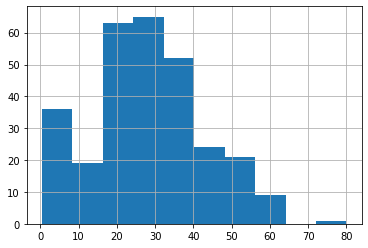

In [16]:
train[train['Survived'] == 1]["Age"].hist()

In [17]:
train[train['Survived'] == 1]["Age"].describe()

count    290.000000
mean      28.343690
std       14.950952
min        0.420000
25%       19.000000
50%       28.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

A majority of survivors are ages 20-40 and 0-10 (infants).

**Conclusion**:  
Following the assumption:  
(Women & Children -> Rich -> Everyone Else),  
it's reasonable to see that infants had high survival rate. The 20-40 age bracket should incompass most of the women too.

### Fare

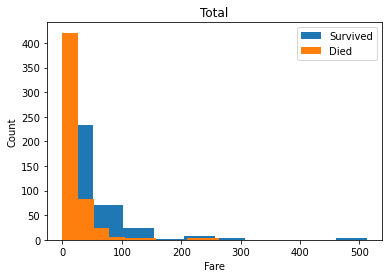

In [18]:
plt.hist(train[(train['Survived'] == 1)]['Fare'], label='Survived')
plt.hist(train[(train['Survived'] == 0) ]['Fare'], label='Died')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Total')
plt.legend(loc='best')
plt.show()

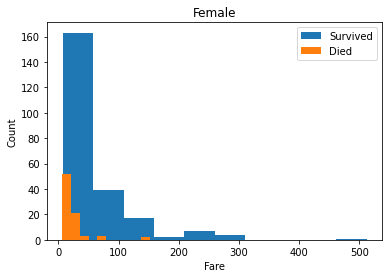

In [19]:
plt.hist(train[(train['Survived'] == 1) & (train['Sex'] == 'female')]['Fare'], label='Survived')
plt.hist(train[(train['Survived'] == 0) & (train['Sex'] == 'female')]['Fare'], label='Died')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Female')
plt.legend(loc='best')
plt.show()

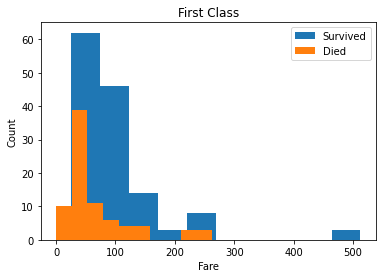

In [20]:
plt.hist(train[(train['Survived'] == 1) & (train['Pclass'] == 1)]['Fare'], label='Survived')
plt.hist(train[(train['Survived'] == 0) & (train['Pclass'] == 1)]['Fare'], label='Died')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('First Class')
plt.legend(loc='best')
plt.show()

Looking at the Total plot, most survivors paid a higher fare. This is further supported by looking at the female and first class plots which were correlated with survival rate.

**Conclusion**:  
It seems likely that fare plays a role in determining survival rate. People who paid more money were also likely to be higher class. It is safe to keep this feature.

### Name

In [21]:
train['Name'].describe()

count                          891
unique                         891
top       Sage, Mr. George John Jr
freq                             1
Name: Name, dtype: object

In [22]:
train[['Name', 'Survived']].groupby(['Name'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Name,Survived
559,"Moss, Mr. Albert Johan",1
472,"Lemore, Mrs. (Amelia Milley)",1
259,"Fortune, Miss. Mabel Helen",1
258,"Fortune, Miss. Alice Elizabeth",1
742,"Silven, Miss. Lyyli Karoliina",1
...,...,...
380,"Hoyt, Mr. William Fisher",0
382,"Humblen, Mr. Adolf Mathias Nicolai Olsen",0
383,"Hunt, Mr. George Henry",0
384,"Ibrahim Shawah, Mr. Yousseff",0


It seems like every name has a title associated with it "Mr.", "Miss.", "Mrs."

**Conclusion**:  
These titles can be extracted such that it further emphasizes the fact that women were more likely to survive than men. This feature should be transformed into one with just titles.

### Summary
***
Columns:

0.   PassengerId  - Drop
1.   Survived     - Keep. Split to y_train values
2.   Pclass       - Keep 
3.   Name         - Keep. Transform into titles
4.   Sex          - Keep. Transform into 0/1
5.   Age          - Keep (fill NA values). Transform into age ranges
6.   SibSp        - Keep. Combine with Parch into Family
7.   Parch        - Keep. Combine with SibSp into Family
8.   Ticket       - Drop
9.   Fare         - Keep (fill NA values). Transform into fare ranges
10.   Cabin        - Drop
11.  Embarked     - Keep (fill NA values). Transform into 0/1/2

## 2. Data Wrangling and Preparation

In [23]:
# Drop columns: Ticket, Cabin
# Drop PassengerID later, need for test submissions
for dataset in ship_sets:
    dataset.drop(["Ticket", "Cabin"], axis=1, inplace=True)

In [24]:
# Convert Sex to binary values: 'female' = 1, 'male' = 0
for dataset in ship_sets:
    dataset["Sex"] = (dataset["Sex"] == 'female').astype(int)

In [25]:
# Fill in missing Fare value in test set
test['Fare'].fillna(test['Fare'].median(), inplace=True)

In [26]:
# Fill in missing Embarked values in train set with highest frequency
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [27]:
train['Embarked'].fillna('S', inplace=True)

In [28]:
# Convert Embarked to numerical values: S = 0, Q = 1, C = 2
loc_to_num = {'S' : 0, 'Q': 1, 'C': 2}
for dataset in ship_sets:
    dataset['Embarked'] = dataset['Embarked'].map(loc_to_num)

In [29]:
# Combine SibSp and Parch to Family
# Convert Family into binary values: 'have family >= 1' = 1, otherwise = 0

for dataset in ship_sets:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch']
    dataset['Family'] = (dataset['Family'] >= 1).astype(int)
    dataset.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [30]:
# Compute median for each Sex and Pclass subset
# Replace missing Age values with median values

for dataset in ship_sets:
    for sex in range(2):
        for econ_class in range(1, 4):
            median_val = dataset.loc[((dataset.Sex == sex) & 
                                    (dataset.Pclass == econ_class),
                                    'Age')].median()
            dataset.loc[((dataset.Age.isnull()) & (dataset.Sex == sex) &                                (dataset.Pclass == econ_class)), 'Age'] = median_val

In [31]:
# Datermine Age ranges from values

_, age_bins = pd.cut(train['Age'], 5, retbins=True)
age_bins

array([ 0.34042, 16.336  , 32.252  , 48.168  , 64.084  , 80.     ])

In [32]:
# Replace Age values with range
for dataset in ship_sets:
    dataset.loc[(dataset['Age'] < age_bins[1]), 'Age'] = 0
    dataset.loc[((age_bins[1] <= dataset['Age']) 
                & (dataset['Age'] < age_bins[2]), 'Age')] = 1
    dataset.loc[((age_bins[2] <= dataset['Age']) 
                & (dataset['Age'] < age_bins[3]), 'Age')] = 2
    dataset.loc[((age_bins[3] <= dataset['Age']) 
                & (dataset['Age'] < age_bins[4]), 'Age')] = 3
    dataset.loc[(age_bins[4] <= dataset['Age']), 'Age'] = 4

In [33]:
# Datermine Fare ranges from values

_, fare_bins = pd.qcut(train['Fare'], 4, retbins=True)
fare_bins

array([  0.    ,   7.9104,  14.4542,  31.    , 512.3292])

In [34]:
# Replace Fare values with range
for dataset in ship_sets:
    dataset.loc[(dataset['Fare'] < fare_bins[1]), 'Fare'] = 0
    dataset.loc[((fare_bins[1] <= dataset['Fare']) 
                & (dataset['Fare'] < fare_bins[2]), 'Fare')] = 1
    dataset.loc[((fare_bins[2] <= dataset['Fare']) 
                & (dataset['Fare'] < fare_bins[3]), 'Fare')] = 2
    dataset.loc[(fare_bins[3] <= dataset['Fare']), 'Fare'] = 3

In [35]:
# Extract titles from Names (Mr., Miss., Mrs., etc)

pattern = r'([a-zA-Z]+\.)'

titles = train.Name.str.extract(pattern)[0]
titles.value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Mlle.          2
Col.           2
Mme.           1
Capt.          1
Lady.          1
Sir.           1
Don.           1
Countess.      1
Jonkheer.      1
Ms.            1
Name: 0, dtype: int64

In [36]:
# Convert names to titles
# Convert Titles into ordinal numbers
# Drop Name column

for dataset in ship_sets:
    dataset["Name"] = titles
    dataset["Title"] = 0
    dataset.loc[dataset['Name'] == 'Mr.', 'Title'] = 1
    dataset.loc[dataset['Name'].isin(['Miss.', 'Ms.']), 'Title'] = 2
    dataset.loc[dataset['Name'] == 'Mrs.', 'Title'] = 3
    dataset.loc[dataset['Name'] == 'Master.', 'Title'] = 4
    dataset.loc[dataset['Name'].isin(['Dr.', 'Rev.', 'Major.', 'Col.', 'Mlle.',                                       'Capt.', 'Jonkheer.', 'Lady.', 'Mme.',                                          'Countess.', 'Don.', 'Sir.']), 
                                       'Title'] = 5
    dataset.drop('Name', axis=1, inplace=True)

In [37]:
# # Create Age*Pclass column

# for dataset in ship_sets:
#     dataset["Age_class"] = dataset['Age'] * dataset['Pclass']

## 3. Training a Model

In [38]:
# Split into X, y values

X_train = train.drop("PassengerId", axis=1)
y_train = X_train.pop('Survived')
X_test = test.drop("PassengerId", axis=1).copy()

In [42]:
# Train a Random Forest

random_forest = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,                                            n_jobs=-1, oob_score=True)
random_forest.fit(X_train, y_train)
random_forest.oob_score_

0.8103254769921436

In [48]:
y_pred = random_forest.predict(X_test)

## 4. Submit Results

In [49]:
submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': y_pred})
submission.to_csv('Submission.csv', index=False)